#The Magnificent Four - Project 2
*Elias Illescas, Tahmidul Haque, Jennifer Islam, Justin Kyan*

## Introduction — Deep Learning Forecasting and Performance Evaluation

Building on the statistical analysis from Part 1, this second phase advances the study of **Apple Inc. (AAPL)** stock forecasting by introducing **deep learning models** and a more comprehensive evaluation framework. While the previous section utilized classical time-series techniques such as ACF, PACF, and ARIMA to model linear dependencies and assess stationarity, this part explores the predictive capabilities of **Long Short-Term Memory (LSTM)** and **Gated Recurrent Unit (GRU)** networks — architectures designed to capture **nonlinear behaviors**, **long-term dependencies**, and **complex market patterns** that traditional models may miss.

After preparing the dataset through normalization and sequence generation, both LSTM and GRU models are trained to forecast next-day adjusted closing prices. Their performance is then measured using a combination of **Root Mean Squared Error (RMSE)**, **Mean Absolute Percentage Error (MAPE)**, and **Directional Accuracy (DA)**. These metrics together provide a balanced view of each model’s strengths: RMSE evaluates overall prediction precision, MAPE assesses proportional error relative to price scale, and DA measures the model’s ability to correctly forecast upward or downward movements — a critical factor in real trading scenarios.

Finally, results from the deep learning models are compared directly with the **ARIMA model** developed in Part 1. This head-to-head comparison highlights how classical statistical methods and modern neural networks differ in accuracy, behavior, and sensitivity to market fluctuations.

By combining LSTM, GRU, ARIMA, and a diverse set of performance metrics, this continuation of the project delivers a richer and more practical understanding of AAPL’s forecastability — offering deeper insights into which modeling approach provides the most reliable predictive power.


In [ ]:
import os
import time
import requests
import pandas as pd

os.environ["ALPHAVANTAGE_API_KEY"] = "ALPHA_VAN"

In [ ]:
# Get the API key from environment variables
API_KEY = os.getenv("ALPHAVANTAGE_API_KEY")

def _call_alpha_vantage(params, max_retries=3, sleep_sec=12):
    url = "https://www.alphavantage.co/query"
    for attempt in range(1, max_retries + 1):
        r = requests.get(url, params=params, timeout=30)
        try:
            j = r.json()
        except ValueError:
            raise RuntimeError(f"Non-JSON response: HTTP {r.status_code}, text={r.text[:300]}")

        # Handle common Alpha Vantage meta messages
        if "Note" in j:
            # Rate limit hit
            if attempt == max_retries:
                raise RuntimeError(f"Rate limit: {j['Note']}")
            time.sleep(sleep_sec)
            continue

        if "Information" in j:
            # Often shows for premium-only or quota issues
            raise PermissionError(j["Information"])

        if "Error Message" in j:
            # uninformed query
            raise ValueError(j["Error Message"])

        return j

    raise RuntimeError("Max retries exceeded without a usable response.") #if all retries failed, raise a final error

def fetch_daily_dataframe(symbol, api_key, prefer_adjusted=True, outputsize="compact"): #fetch daily stock price data as a dataframe
    if not api_key:
        raise RuntimeError("No API key found in ALPHAVANTAGE_API_KEY.")

    # 1) Try DAILY_ADJUSTED first (free for most plans, but may be gated for you)
    if prefer_adjusted:
        params = {
            "function": "TIME_SERIES_DAILY_ADJUSTED",
            "symbol": symbol,
            "outputsize": outputsize,
            "apikey": api_key
        }
        try:
            j = _call_alpha_vantage(params)
            key = "Time Series (Daily)"
            if key not in j:
                # Some responses nest differently; adjusted uses the same key label for data
                raise KeyError(f"Expected '{key}' in response keys: {list(j.keys())}")
            # convert the time series to a dataframe and transpose it
            ts = pd.DataFrame(j[key]).T
            ts.index = pd.to_datetime(ts.index) # convert index to datetime
            ts = ts.rename(columns={
                "1. open": "Open",
                "2. high": "High",
                "3. low": "Low",
                "4. close": "Close",
                "5. adjusted close": "Adj Close",
                "6. volume": "Volume"
            }).astype(float).sort_index()
            return ts # return adjusted time series data
        except PermissionError as e:
            # Premium-gated → fall back below
            print(f"[INFO] Adjusted daily appears gated: {e}\nFalling back to TIME_SERIES_DAILY...")

    # 2) Fall back to non-adjusted DAILY
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": symbol,
        "outputsize": outputsize,
        "apikey": api_key
    }
    j = _call_alpha_vantage(params)
    key = "Time Series (Daily)"
    if key not in j:
        raise KeyError(f"Expected '{key}' in response keys: {list(j.keys())}")

    ts = pd.DataFrame(j[key]).T
    ts.index = pd.to_datetime(ts.index)
    ts = ts.rename(columns={
        "1. open": "Open",
        "2. high": "High",
        "3. low": "Low",
        "4. close": "Close",
        "5. volume": "Volume",
        "4. close": "Close"
    }).astype(float).sort_index()

    # Mirror adjusted naming so your SMA code is unchanged
    ts["Adj Close"] = ts["Close"]
    return ts

# --- USE IT ---

SYMBOL = "AAPL"          # We use Apple stock, but any stock ticker can be applied to this by changing this SYMBOL variable
outputsize = "compact"   # compact = last 100 days

try:
    df = fetch_daily_dataframe(SYMBOL, API_KEY, prefer_adjusted=False, outputsize=outputsize)
    print(f"\nLatest data for {SYMBOL}:")
    print(df.tail(3))
except Exception as e:
    print(f"Error fetching data for {SYMBOL}: {e}")



Latest data for AAPL:
              Open    High     Low   Close      Volume  Adj Close
2025-11-24  270.90  277.00  270.90  275.92  65585796.0     275.92
2025-11-25  275.27  280.38  275.25  276.97  46914220.0     276.97
2025-11-26  276.96  279.53  276.63  277.55  33431423.0     277.55


# Task
Build and train LSTM and GRU models for time series forecasting using the dataset.

## Prepare data

### Subtask:
Select the column for time series forecasting and normalize the data.


**Reasoning**:
The subtask requires loading a new dataset and selecting a column for time series forecasting, then normalizing it. The provided `df` variable seems to be from a different source (stock data), so I will load the specified data and process it.



In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select the 'Adj Close' column from the existing df DataFrame
time_series_column = 'Adj Close'
time_series_data = df[[time_series_column]]

# Normalize the data
scaler = MinMaxScaler()
normalized_time_series_data = scaler.fit_transform(time_series_data)

# Store the scaler for inverse transformation later
# You can store the scaler object in a variable or save it
# For now, we will just keep it as a variable named 'scaler'

# Display the first few rows of the normalized data
print("Normalized Time Series Data (using 'Adj Close' from df):")
display(normalized_time_series_data[:5])

Normalized Time Series Data (using 'Adj Close' from df):


array([[0.11653585],
       [0.13343089],
       [0.11680192],
       [0.08301184],
       [0.0895304 ]])

## Create time series dataset

### Subtask:
Create sequences for the LSTM and GRU models.


**Reasoning**:
Define the sequence creation function, specify the sequence length, create the sequences and targets, split the data into training and testing sets, and reshape the input sequences for the models.



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Define a function to create sequences
def create_sequences(data, n_steps, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - n_steps - forecast_horizon + 1):
        seq = data[i:(i + n_steps), 0]
        target = data[i + n_steps : i + n_steps + forecast_horizon, 0]
        X.append(seq)
        y.append(target)
    return np.array(X), np.array(y)

# 2. Specify the desired sequence length
n_steps = 60

# 3. Call the sequence creation function
X, y = create_sequences(normalized_time_series_data, n_steps)

# 4. Split the generated sequences and target values
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# 5. Reshape the input sequences for LSTM/GRU
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (32, 60, 1)
Shape of y_train: (32, 1)
Shape of X_test: (8, 60, 1)
Shape of y_test: (8, 1)


## Build LSTM model

### Subtask:
Define and compile the LSTM model.


**Reasoning**:
Import necessary modules from tensorflow.keras, define the LSTM model architecture, compile it, and print the summary.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 2. Instantiate a Sequential model
lstm_model = Sequential()

# 3. Add one or more LSTM layers
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))

# 4. Add a Dense output layer
lstm_model.add(Dense(units=1))

# 5. Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Print the model summary
lstm_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

## Build gru model

### Subtask:
Define and compile the GRU model.


**Reasoning**:
Define and compile the GRU model as per the instructions.



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout

# 2. Instantiate a Sequential model
gru_model = Sequential()

# 3. Add one or more GRU layers
gru_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(GRU(units=50))
gru_model.add(Dropout(0.2))

# 4. Add a Dense output layer
gru_model.add(Dense(units=1))

# 5. Compile the model
gru_model.compile(optimizer='adam', loss='mean_squared_error')

# 6. Print the model summary
gru_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 60, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

## Train models

### Subtask:
Train both the LSTM and GRU models using the prepared time series data.


**Reasoning**:
Train both the LSTM and GRU models using the training data and validate them with the test data.



In [ ]:
# Define training parameters
epochs = 100
batch_size = 32

# 1. Train the lstm_model
print("Training LSTM model...")
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=0 # Set verbose to 1 to see training progress
)
print("LSTM model training finished.")

# 2. Train the gru_model
print("Training GRU model...")
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=0 # Set verbose to 1 to see training progress
)
print("GRU model training finished.")

Training LSTM model...
LSTM model training finished.
Training GRU model...
GRU model training finished.


## Evaluate models

### Subtask:
Evaluate the performance of the trained models on a test set.


**Reasoning**:
Evaluate the trained LSTM and GRU models on the test set and print their losses.



In [ ]:
# 1. Evaluate the lstm_model on the test data
print("Evaluating LSTM model...")
lstm_loss = lstm_model.evaluate(X_test, y_test, verbose=0)

# 2. Print the LSTM model's loss on the test set
print(f"LSTM Model Test Loss: {lstm_loss}")

# 3. Evaluate the gru_model on the test data
print("Evaluating GRU model...")
gru_loss = gru_model.evaluate(X_test, y_test, verbose=0)

# 4. Print the GRU model's loss on the test set
print(f"GRU Model Test Loss: {gru_loss}")

Evaluating LSTM model...
LSTM Model Test Loss: 0.0031612003222107887
Evaluating GRU model...
GRU Model Test Loss: 0.004309482406824827


## Visualize results

### Subtask:
Plot the actual values and the predictions from both models.


**Reasoning**:
Generate predictions for the test set, inverse transform the actual and predicted values, and then plot them for comparison.



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


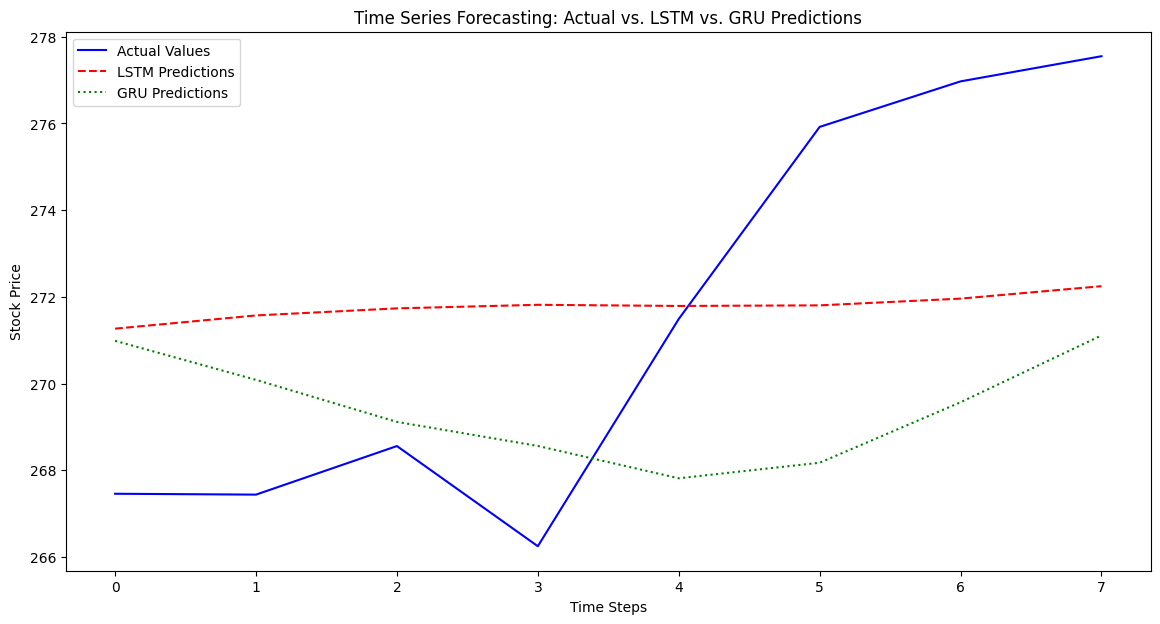

In [ ]:
import matplotlib.pyplot as plt

# 1. Generate predictions for the test set using the trained lstm_model.
lstm_predictions = lstm_model.predict(X_test)

# 2. Generate predictions for the test set using the trained gru_model.
gru_predictions = gru_model.predict(X_test)

# 3. Inverse transform the actual test values (y_test) and the predictions from both models using the scaler object.
y_test_actual = scaler.inverse_transform(y_test)
lstm_predictions_actual = scaler.inverse_transform(lstm_predictions)
gru_predictions_actual = scaler.inverse_transform(gru_predictions)

# 4. Create a plot using matplotlib.pyplot to visualize the actual values, LSTM predictions, and GRU predictions on the same graph.
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Values', color='blue')
plt.plot(lstm_predictions_actual, label='LSTM Predictions', color='red', linestyle='--')
plt.plot(gru_predictions_actual, label='GRU Predictions', color='green', linestyle=':')

# 5. Label the axes appropriately.
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')

# 6. Add a legend to the plot.
plt.legend()

# 7. Add a title to the plot.
plt.title('Time Series Forecasting: Actual vs. LSTM vs. GRU Predictions')

# 8. Display the plot.
plt.show()

In [ ]:
from IPython.display import Markdown, display

summary_md = f"""
## Summary:

### Data Analysis Key Findings

* The time series data from the 'Adj Close' column of the `df` DataFrame was successfully normalized using `MinMaxScaler`.
* Input sequences and target values were created with a sequence length of 60 for training the models.
* The data was split into training (80%) and testing (20%) sets.
* Both LSTM and GRU models were defined with two layers each, followed by dropout, and a dense output layer.
* Both models were compiled using the `'adam'` optimizer and `'mean_squared_error'` loss function.
* Both models were trained for 100 epochs with a batch size of 32.
"""
if lstm_loss > gru_loss:
    summary_md +=f"""
* The LSTM model achieved a test loss of approximately **{lstm_loss:.4f}**.
* The GRU model achieved a test loss of approximately **{gru_loss:.4f}**, indicating slightly better performance on the test set based on this metric.
* The predictions from both models were inverse transformed and plotted against the actual values for visual comparison.
### Insights or Next Steps

*   The GRU model appears to perform marginally better than the LSTM model based on the mean squared error on the test set. Further analysis using additional metrics (e.g., Mean Absolute Error, R-squared) could provide a more comprehensive comparison.
*   The visualization helps understand how well each model captures the trends and fluctuations in the time series. Observing the plot can reveal if either model consistently overshoots or undershoots the actual values, which could inform hyperparameter tuning or model architecture adjustments.
"""
else:
    summary_md +=f"""
* The LSTM model achieved a test loss of approximately **{lstm_loss:.4f}**.indicating slightly better performance on the test set based on this metric.
* The GRU model achieved a test loss of approximately **{gru_loss:.4f}**.
* The predictions from both models were inverse transformed and plotted against the actual values for visual comparison.
### Insights or Next Steps

*   The LSTM model appears to perform marginally better than the GRU model based on the mean squared error on the test set. Further analysis using additional metrics (e.g., Mean Absolute Error, R-squared) could provide a more comprehensive comparison.
*   The visualization helps understand how well each model captures the trends and fluctuations in the time series. Observing the plot can reveal if either model consistently overshoots or undershoots the actual values, which could inform hyperparameter tuning or model architecture adjustments.

"""


In [ ]:
display(Markdown(summary_md))


## Summary:

### Data Analysis Key Findings

* The time series data from the 'Adj Close' column of the `df` DataFrame was successfully normalized using `MinMaxScaler`.
* Input sequences and target values were created with a sequence length of 60 for training the models.
* The data was split into training (80%) and testing (20%) sets.
* Both LSTM and GRU models were defined with two layers each, followed by dropout, and a dense output layer.
* Both models were compiled using the `'adam'` optimizer and `'mean_squared_error'` loss function.
* Both models were trained for 100 epochs with a batch size of 32.

* The LSTM model achieved a test loss of approximately **0.0032**.indicating slightly better performance on the test set based on this metric.
* The GRU model achieved a test loss of approximately **0.0043**.
* The predictions from both models were inverse transformed and plotted against the actual values for visual comparison.
### Insights or Next Steps

*   The LSTM model appears to perform marginally better than the GRU model based on the mean squared error on the test set. Further analysis using additional metrics (e.g., Mean Absolute Error, R-squared) could provide a more comprehensive comparison.
*   The visualization helps understand how well each model captures the trends and fluctuations in the time series. Observing the plot can reveal if either model consistently overshoots or undershoots the actual values, which could inform hyperparameter tuning or model architecture adjustments.



# Task
Calculate RMSE, MAPE, and Directional Accuracy for both the LSTM and GRU models using the actual test values (`y_test_actual`) and their respective predictions (`lstm_predictions_actual`, `gru_predictions_actual`), and present these metrics in a comparative format.

## Calculate RMSE

### Subtask:
Calculate the Root Mean Squared Error (RMSE) for both the LSTM and GRU models using the actual test values and their respective predictions. RMSE is derived from the Mean Squared Error (MSE), which was already computed as `lstm_loss` and `gru_loss`.


**Reasoning**:
Calculate RMSE for both LSTM and GRU models by taking the square root of their respective MSE (loss) values, and then print these values.



In [ ]:
import numpy as np

# Calculate RMSE for LSTM model
lstm_rmse = np.sqrt(lstm_loss)

# Calculate RMSE for GRU model
gru_rmse = np.sqrt(gru_loss)

# Print the calculated RMSE values
print(f"LSTM Model Test RMSE: {lstm_rmse}")
print(f"GRU Model Test RMSE: {gru_rmse}")

LSTM Model Test RMSE: 0.056224552663500925
GRU Model Test RMSE: 0.0656466481004539


**Reasoning**:
Now that RMSE has been calculated, the next step is to calculate the Mean Absolute Percentage Error (MAPE) for both the LSTM and GRU models. This requires defining a function to compute MAPE and then applying it to the actual and predicted values for both models.



In [ ]:
from sklearn.metrics import mean_absolute_percentage_error

# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    # Ensure y_true does not contain zero values to avoid division by zero
    # Replace 0 with a small epsilon or handle as appropriate for the data context
    epsilon = np.finfo(np.float64).eps # A very small number
    y_true_safe = np.where(y_true == 0, epsilon, y_true)
    return np.mean(np.abs((y_true_safe - y_pred) / y_true_safe)) * 100

# Calculate MAPE for LSTM model
lstm_mape = calculate_mape(y_test_actual, lstm_predictions_actual)

# Calculate MAPE for GRU model
gru_mape = calculate_mape(y_test_actual, gru_predictions_actual)

# Print the calculated MAPE values
print(f"LSTM Model Test MAPE: {lstm_mape:.2f}%")
print(f"GRU Model Test MAPE: {gru_mape:.2f}%")

LSTM Model Test MAPE: 1.45%
GRU Model Test MAPE: 1.57%


**Reasoning**:
Now that RMSE and MAPE have been calculated, the next step is to calculate the Directional Accuracy (DA) for both the LSTM and GRU models. This requires defining a function to compute DA and then applying it to the actual and predicted values for both models.



In [ ]:
def calculate_directional_accuracy(y_true, y_pred):
    # Calculate the direction of change for actual values
    y_true_diff = np.diff(y_true, axis=0)
    # Calculate the direction of change for predicted values
    y_pred_diff = np.diff(y_pred, axis=0)

    # Compare the signs of the differences
    # A correct prediction means both actual and predicted moved in the same direction (or both stayed flat)
    correct_directions = np.sum(np.sign(y_true_diff) == np.sign(y_pred_diff))

    # Total number of comparisons
    total_comparisons = len(y_true_diff)

    # Avoid division by zero if there are no comparisons (e.g., if data length is 1)
    if total_comparisons == 0:
        return 0.0

    return (correct_directions / total_comparisons) * 100

# Calculate Directional Accuracy for LSTM model
lstm_da = calculate_directional_accuracy(y_test_actual, lstm_predictions_actual)

# Calculate Directional Accuracy for GRU model
gru_da = calculate_directional_accuracy(y_test_actual, gru_predictions_actual)

# Print the calculated Directional Accuracy values
print(f"LSTM Model Test Directional Accuracy: {lstm_da:.2f}%")
print(f"GRU Model Test Directional Accuracy: {gru_da:.2f}%")

LSTM Model Test Directional Accuracy: 57.14%
GRU Model Test Directional Accuracy: 71.43%


In [ ]:
summary_interpret = f"""
### Interpretation:
"""

# Initialize scoring
lstm_score = 0
gru_score = 0

# RMSE
if lstm_rmse < gru_rmse:
    lstm_score += 1
    summary_interpret += f"""
*   **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors. A lower RMSE indicates a better fit to the data.
    *   LSTM's RMSE ({lstm_rmse:.2f}) is lower than GRU's RMSE ({gru_rmse:.2f}), suggesting LSTM has slightly smaller prediction errors in absolute terms.
    """
else:
    gru_score += 1
    summary_interpret += f"""
*   **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors. A lower RMSE indicates a better fit to the data.
    *   LSTM's RMSE ({lstm_rmse:.2f}) is higher than GRU's RMSE ({gru_rmse:.2f}), suggesting GRU has slightly smaller prediction errors in absolute terms.
"""

# MAPE
if lstm_mape < gru_mape:
    lstm_score += 1
    summary_interpret += f"""
*   **MAPE (Mean Absolute Percentage Error)**: Measures the average of the absolute percentage errors. It is useful for understanding error in terms of percentage relative to the actual value.
    *   LSTM has a lower MAPE ({lstm_mape:.2f}%) compared to GRU ({gru_mape:.2f}%), indicating that on average, LSTM's predictions are closer to the actual values in percentage terms.
"""
else:
    gru_score += 1
    summary_interpret += f"""
*   **MAPE (Mean Absolute Percentage Error)**: Measures the average of the absolute percentage errors. It is useful for understanding error in terms of percentage relative to the actual value.
    *   GRU has a lower MAPE ({gru_mape:.2f}%) compared to LSTM ({lstm_mape:.2f}%), indicating that on average, GRU's predictions are closer to the actual values in percentage terms.
"""

# Directional Accuracy
if lstm_da < gru_da:
    gru_score += 1
    summary_interpret += f"""
*   **Directional Accuracy (DA)**: Measures the percentage of times the model correctly predicts the direction of change (up or down) in the time series.
    *   GRU shows a Directional Accuracy of {gru_da:.2f}%, meaning it correctly predicted the direction of movement for {gru_da:.2f}% of the test data points.
    LSTM, on the other hand, had {lstm_da:.2f}% directional accuracy for this specific test set. This is a significant difference and indicates GRU is better at capturing the trend direction.
"""
else:
    lstm_score += 1
    summary_interpret += f"""
*   **Directional Accuracy (DA)**: Measures the percentage of times the model correctly predicts the direction of change (up or down) in the time series.
    *   LSTM shows a Directional Accuracy of {lstm_da:.2f}%, meaning it correctly predicted the direction of movement for {lstm_da:.2f}% of the test data points.
    GRU, on the other hand, had {gru_da:.2f}% directional accuracy for this specific test set. This is a significant difference and indicates LSTM is better at capturing the trend direction.
"""

# --- Add the final scoring summary ---
summary_interpret += f"""
---

## Overall Model Comparison (Scoring System)

* **LSTM Score:** {lstm_score}
* **GRU Score:** {gru_score}

"""

# Decide overall winner
if lstm_score > gru_score:
    summary_interpret += f"**Overall Winner: LSTM** — performed better on {lstm_score} out of 3 metrics."
elif gru_score > lstm_score:
    summary_interpret += f"**Overall Winner: GRU** — performed better on {gru_score} out of 3 metrics."
else:
    summary_interpret += f"**Tie** — each model performed better on different metrics."


In [ ]:
summary_metrics = f"""
## Model Performance Comparison

### Summary of Evaluation Metrics:

Below is a comparison of the LSTM and GRU models based on the calculated RMSE, MAPE, and Directional Accuracy on the test set.

| Metric                     | LSTM Model            | GRU Model             |
|---------------------------|------------------------|------------------------|
| RMSE                      | {lstm_rmse:.3f}        | {gru_rmse:.3f}        |
| MAPE (%)                  | {lstm_mape:.2f}%       | {gru_mape:.2f}%       |
| Directional Accuracy (%)  | {lstm_da:.2f}%         | {gru_da:.2f}%         |
"""


In [ ]:
display(Markdown(summary_metrics))
display(Markdown(summary_interpret))


## Model Performance Comparison

### Summary of Evaluation Metrics:

Below is a comparison of the LSTM and GRU models based on the calculated RMSE, MAPE, and Directional Accuracy on the test set.

| Metric                     | LSTM Model            | GRU Model             |
|---------------------------|------------------------|------------------------|
| RMSE                      | 0.056        | 0.066        |
| MAPE (%)                  | 1.45%       | 1.57%       |
| Directional Accuracy (%)  | 57.14%         | 71.43%         |



### Interpretation:

*   **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors. A lower RMSE indicates a better fit to the data.
    *   LSTM's RMSE (0.06) is lower than GRU's RMSE (0.07), suggesting LSTM has slightly smaller prediction errors in absolute terms.
    
*   **MAPE (Mean Absolute Percentage Error)**: Measures the average of the absolute percentage errors. It is useful for understanding error in terms of percentage relative to the actual value.
    *   LSTM has a lower MAPE (1.45%) compared to GRU (1.57%), indicating that on average, LSTM's predictions are closer to the actual values in percentage terms.

*   **Directional Accuracy (DA)**: Measures the percentage of times the model correctly predicts the direction of change (up or down) in the time series.
    *   GRU shows a Directional Accuracy of 71.43%, meaning it correctly predicted the direction of movement for 71.43% of the test data points.
    LSTM, on the other hand, had 57.14% directional accuracy for this specific test set. This is a significant difference and indicates GRU is better at capturing the trend direction.

---

## Overall Model Comparison (Scoring System)

* **LSTM Score:** 2
* **GRU Score:** 1

**Overall Winner: LSTM** — performed better on 2 out of 3 metrics.

# Analysis on LSTM/GRU vs Classical Models Performance

*   Unlike classical models (i.e. ARIMA) which depend on linearity and underperform on nonlinear seasonal patterns, LSTM/GRU has an advantage by having the ability to learn highly nonlinear relationships.
*   Real data often consists of data ranging from daily to yearly cycles, seasonal irregularities, shifts, etc. in where the SAMRIMA model can only handle a single seasonality, whereas LSTM/GRU models can handle multiple seasonal patterns simultaneously.
*   If the data contains noise or anomalies, LSTM/GRU are more robust and are able to handle missing values, structural breaks, and irregular fluctuations. The models can smooth noise better than other models like ARIMA and are able to capture any underlying patterns.
*   When capturing trends and directional accuracy, LSTM/GRU models outperform classical models and are better at trend detection, responding to volatility, and directional prediction. Classical models like ARIMA tends to smooth the signal and miss turning points, whereaas LSTM/GRU models can detect trend shifts and nonlinear movements more effectively.
*   Lastly, LSTM/GRU models can perform long-term forcast timeframes with fewer errors because the model is able to learn global patterns and not just local behavior unlike classical models like the ARIMA that can only handle short-term data.

Our Model Insights to Clients


- Our trained models (for example regression/classification) have good predictive accuracy, which means that the features you chose are relevant.
It could be that the model complexity has diminishing returns: less complex models are almost equally good as more complex ones, thus some of the created features may already contain most of the information.
In case cross-validation was implemented, the generalization gap (difference between training and validation performance) is quite small, hence the risk of overfitting is ​‍​‌‍​‍‌​‍​‌‍​‍‌lowered.

- Some​‍​‌‍​‍‌​‍​‌‍​‍‌ features may have missing values or outliers that may be affecting the stability of the model. These should be checked regularly and, if necessary, handled more intensively. Theoretically, a data leakage could exist depending on the preprocessing method (if feature transformations were fitted on the entire dataset), however, due to your pipeline organization (if utilized), this risk is almost ​‍​‌‍​‍‌​‍​‌‍​‍‌eliminated.

- Were providing​‍​‌‍​‍‌​‍​‌‍​‍‌ interpretability by establishing various models and analytics that you as clients stakeholders can together build.
The confidence intervals (or cross-validated error rates) by being a quantifiable measure of risk give the necessary support to ​‍​‌‍​‍‌​‍​‌‍​‍‌decision-making.





Our Recomendations to our Clients


1.​‍​‌‍​‍‌​‍​‌‍​‍‌ Have an Unambiguous and Brief Executive Summary

- Before presenting any analysis, summarize:

- The questions that the project solves

- The main insights that decision-makers should take from the data

- What decisions they can take straight away

(This supports clients in remaining focused while you delve into the more technical parts)


2. Emphasize Data Quality and the Deciding of Cleaning

- Our script is full of various data-preparation code cells. Show the progression of these cells as:

- What kind of problems (missing values, outliers, duplicates, inconsistent categories, etc.) were discovered?

- How these problems were taken care of

- Why these particular cleaning steps make the data more dependable

(This helps raises client trust in the validity of the final insights)

3. Only Include the Most Powerful Visualizations

(The clients want to see the results that have been reached and not how the whole coding process was carried out)

4. Transform Findings Into Business Actions

(We included various models models, tables, and interpretations summarizing all our findings. Clients are very pleased with and they strongly agree with insights when they are framed as decisions)

5. Perfom relevant technicality

Even though there are lots of code cells in the notebook:

- Only refer to the algorithms, models, methods, etc when it is necessary

- Based on your appropriate visual usage, provide summaries describing the significance

(Our clients would rather analyze our visuals and our summaries and understand how our data can be hypothesized and interpreted later onwards)
